In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import pandas
import os
import random
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from IPython import display
import time
import shutil
import matplotlib_inline.backend_inline

/userhome/cs/chan0305/ENTER/envs/walkability/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [3]:
def data_preprocess(path):
#     changed=[]
#     def image_format_change(path,new_extension):
#     f=os.listdir(path)
#     for fname in f:
#         pre, ext = os.path.splitext(fname)
#         if ext!='jpg':
#             os.rename(os.path.join(path,fname).replace("\\","/"), os.path.join(path,pre) + new_extension)
#     image_format_change(os.path.join(path,'train').replace("\\","/"),'.jpg')
#     image_format_change(os.path.join(path,'train').replace("\\","/"),'.jpg')
#     with open(os.path.join(path,"inf0_images_final.txt").replace("\\","/"),'r') as f:
#         lines=f.readlines()
#         changed.append(lines[0])
#         for line in lines[1:]:
#             line_ls=line.split('\t')
#             if line_ls[0].split('.')[1]!='jpg"':
#                 line_ls[0]=line_ls[0].split('.')[0]+'.jpg"'
#                 line='\t'.join(line_ls)
#                 # print(line)
#             changed.append(line)    
#     f.close()  
#     with open(os.path.join(path,"inf0_images_final_2.txt").replace("\\","/"),'w') as f:
#     for line in changed:
#         f.write(line)
#     f.close()
    df=pandas.read_csv("info_images.txt" , sep="\t")
    df["Name"]=df["Name"].apply(lambda x : x.lower())
    # ts=pandas.read_csv("trueskill.csv")
    ts=pandas.read_csv("elo100_with_bins_inverse.csv", index_col=0 )
    df2=pandas.merge(df,ts, on='Name')
    return df2

In [1]:
path='data'
df=data_preprocess(path)

In [69]:
df=data_preprocess(path)
df.iloc[:, -100:]

,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,...,bin_90,bin_91,bin_92,bin_93,bin_94,bin_95,bin_96,bin_97,bin_98,bin_99
0,37,38,39,40,39,39,39,39,39,38,...,39,38,39,38,41,40,38,40,39,39
1,38,42,39,39,38,38,38,40,39,38,...,39,40,38,39,38,41,40,37,38,39
2,16,19,15,16,19,17,19,14,20,17,...,19,14,13,18,17,17,18,16,16,13
3,25,26,26,26,25,27,25,26,26,25,...,26,27,26,23,25,26,26,25,25,26
4,29,29,27,30,27,29,30,28,29,28,...,29,27,30,29,29,30,31,24,29,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3025,45,43,45,44,45,45,46,45,45,44,...,43,44,43,45,44,44,43,46,44,44
3026,50,51,52,50,50,48,49,50,48,50,...,50,51,50,50,48,50,52,50,50,49
3027,34,35,34,36,36,37,37,36,36,36,...,36,36,36,37,35,34,37,37,35,35
3028,39,40,40,39,40,41,40,40,41,40,...,40,40,40,41,40,39,40,40,40,41


In [4]:
path='data'
df=data_preprocess(path)
# df=df.iloc[:, :-1]
# print(df.head())
bins=df.iloc[:, -100:]
# print(bins.head())
# bins.head()
labels=bins.apply(pandas.Series.value_counts, axis=1).fillna(0)
# labels.head()
labels=labels.div(labels.sum(axis=1),axis=0)
if labels.columns.tolist() != [i for i in range(100)]:
    col=labels.columns.tolist()
    for i in range(100):
        if i not in col:
            # print(f"adding {i}")
            labels[i]=0
    # print(labels.columns)
    labels=labels[[i for i in range(100)]]
# print(labels)
df=pandas.concat([df,labels] ,axis=1)
df.head()
# df.head()
df.to_csv("abc.csv")

In [8]:
trainDF=pandas.read_csv("trainDF.csv")
train=trainDF["FileName"]
testDF=pandas.read_csv("testDF.csv")
test=testDF["FileName"]
valDF=pandas.read_csv("valDF.csv")
val=valDF["FileName"]

In [79]:
def dupFiles (SrCpath,train,test,val):
    DesTpath=os.path.join(os.getcwd(),"data_overlay")
    os.makedirs(DesTpath, exist_ok=True)
    d_dict={"train":[os.path.join(DesTpath , "train") , train], "test":[os.path.join(DesTpath , "test") , test], "val":[os.path.join(DesTpath , "val") , val]}
    for _,d in d_dict.items():
        print(_)
        p=d[0]
        if os.path.exists(p) and os.path.isdir(p):
            shutil.rmtree(p)
        os.makedirs(p)
        Flist=d[1]
        for fname in Flist:
            # print(fname)
            shutil.copy(os.path.join(SrCpath , fname), p)

In [5]:
def try_gpu():
    return torch.device("cuda:0")

In [6]:
def read_data(path,is_train):
    path=path+("/train" if is_train==True else "/test")
    f=[file for file in os.listdir(path) if os.path.isfile(os.path.join(path,file))]
    l=min(4000,len(f))
    img=[]
    labels=[]
    for fname in f[:l]:
        image=Image.open(os.path.join(path,fname))
        img.append(image)
        # print(fname)
        # print(fname.lower())
        
        # labels.append((df.loc[df["Name"]==fname.lower(),"elo_reduced"].values[0]))
        
        # labels.append(int(df.loc[df["Name"]==fname.lower() , "cls"].values[0]))
        # break
        
        # for bins
        i=df.loc[df["Name"]==fname.lower()].index.item()
        print
        labels.append(df.iloc[i, -100:].tolist())
    return img,labels

In [7]:
class StreetData(torch.utils.data.Dataset):
    def __init__(self,path,device,is_train=True):
        self.path=path
        data,labels=read_data(path,is_train)
        if (is_train):
            self.transform=torchvision.transforms.Compose([
                # torchvision.transforms.ColorJitter(brightness=.5, hue=.3),
                # torchvision.transforms.RandomAffine(degrees=(-20,20),translate=(0.1,0.1),scale=((0.8,1.2)),shear=0.1),                              
                torchvision.transforms.RandomHorizontalFlip(),
                
                # torchvision.transforms.RandomResizedCrop((224,224),scale=(0.7,1),ratio=(0.5,2)),
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                # torchvision.transforms.RandomErasing(p=0.8 , scale=(0.1, 0.5))
                # torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
        else:
            self.transform=torchvision.transforms.Compose([
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                # torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        # print(data,device,labels)
        self.data=[self.transform(img) for img in data]
#         regression
        self.labels=torch.Tensor(labels)
        self.labels=torch.unsqueeze(self.labels,1)
        self.labels=self.labels
        
        
# # #       classification
#         self.labels=torch.Tensor(labels).to(torch.int64)
#         self.labels=self.labels

    def __getitem__(self,idx):
        return (self.data[idx],self.labels[idx])
    def __len__(self):
        return len(self.data)
        
            

In [8]:
batch_size=16
path=os.path.join(os.getcwd(),"data")
print("Train")
street_train=StreetData(path,device=try_gpu(),is_train=True)
print("Test")
street_test=StreetData(path,device=try_gpu(),is_train=False)
train_iter=torch.utils.data.DataLoader(street_train,batch_size,shuffle=True,drop_last=True)
test_iter=torch.utils.data.DataLoader(street_test,batch_size,shuffle=True,drop_last=False)


Train
Test


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0100, 0.0100, 0.3500,
         0.3200, 0.2400, 0.0400, 0.0300, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])


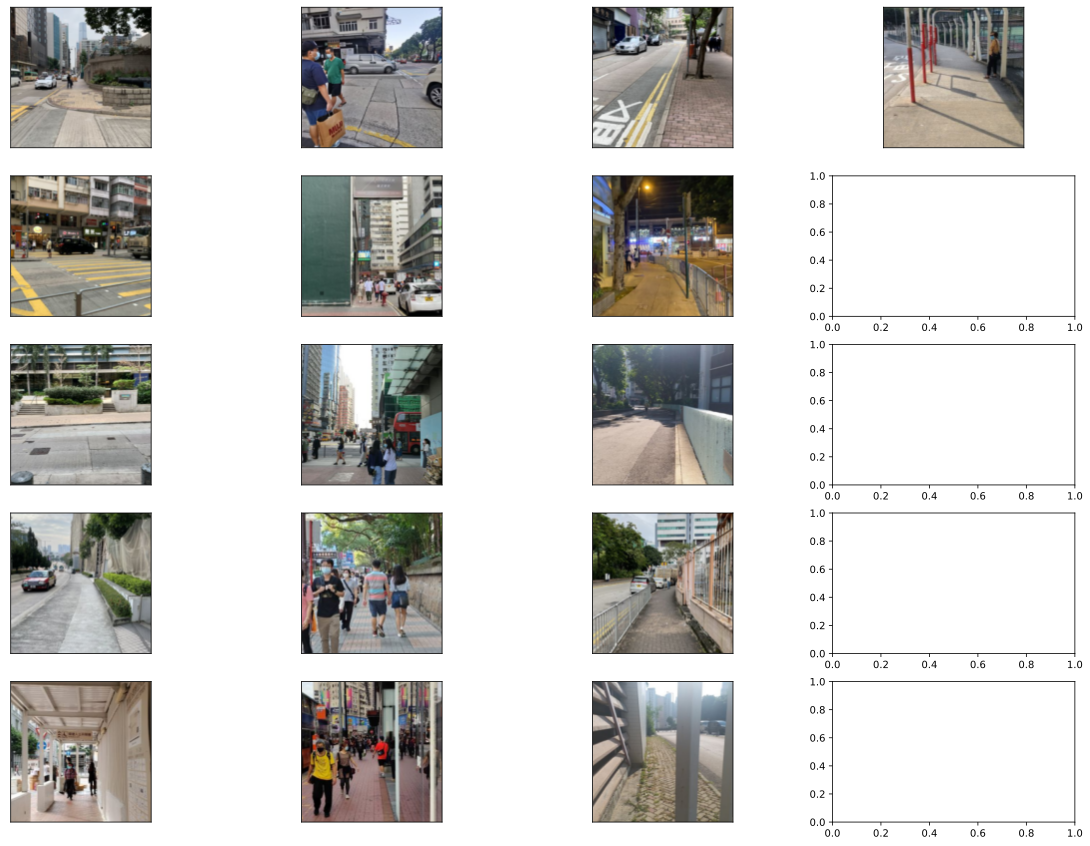

In [9]:
import torchvision.transforms.functional as F
figsize=(20,15)
for x, y in test_iter:
    fix, axs = plt.subplots(nrows=5 , ncols=len(x)//5+1 , figsize=figsize,squeeze=True)
    for i, img in enumerate(x):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[i%5, i//5].imshow(np.asarray(img))
        axs[i%5, i//5].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    print(y[0])
    break

# Swin Transformer

In [15]:
# --------------------------------------------------------
# Swin Transformer
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ze Liu
# --------------------------------------------------------

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w] , indexing="ij"))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(x)

        # FFN
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

In [17]:
# drop_rate (float): Dropout rate. Default: 0
# attn_drop_rate (float): Attention dropout rate. Default: 0
# drop_path_rate (float): Stochastic depth rate. Default: 0.1
pretrained2=SwinTransformer(num_classes=0 , drop_rate=0.5 , attn_drop_rate=0.5 )
net2=nn.Sequential(pretrained2 , nn.Linear(768,128) , nn.Linear(128,1))
net=net2


# ViT

In [22]:
def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return torch.FloatTensor(sinusoid_table)

In [18]:
from timm.models.vision_transformer import PatchEmbed, Block
class PretrainVisionTransformerEncoder(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=0, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, init_values=None,
                 use_learnable_pos_emb=False):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # TODO: Add the cls token
        # self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        if use_learnable_pos_emb:  
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        else:
            # sine-cosine positional embeddings
            self.pos_embed = get_sinusoid_encoding_table(num_patches, embed_dim)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(  # Transformer Encoder
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values)
            for i in range(depth)])
        self.norm =  norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        if use_learnable_pos_emb:
            trunc_normal_(self.pos_embed, std=.02) 
        # trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)
    def forward_features(self, x, mask):
        x = self.patch_embed(x)
        
        # cls_tokens = self.cls_token.expand(batch_size, -1, -1) 
        # x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed.type_as(x).to(x.device).clone().detach()

        B, _, C = x.shape
	# x -> Batch, 196, Channel(768)
	# mask -> Batch, 196
        x_vis = x[~mask].reshape(B, -
                                 1, C) # ~mask means visible
	# x_vis -> Batch, 49, Channel
        for blk in self.blocks:
            x_vis = blk(x_vis)

        x_vis = self.norm(x_vis)
        return x_vis

    def forward(self, x, mask):
        x = self.forward_features(x, mask)
        x = self.head(x)  # Identity()
        return x  # Batch, 49, 768

In [19]:
class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)  
    
    def extra_repr(self) -> str:
        return 'p={}'.format(self.drop_prob)

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

In [20]:
class RandomMaskingGenerator:
    def __init__(self, input_size, mask_ratio):
        if not isinstance(input_size, tuple):
            input_size = (input_size,) * 2

        self.height, self.width = input_size

        self.num_patches = self.height * self.width 
        self.num_mask = int(mask_ratio * self.num_patches)  # 196 * 0.75

    def __repr__(self):
        repr_str = "Maks: total patches {}, mask patches {}".format(
            self.num_patches, self.num_mask
        )
        return repr_str

    def __call__(self):
        mask = np.hstack([ 
            np.zeros(self.num_patches - self.num_mask), 
            np.ones(self.num_mask), 
        ])
        np.random.shuffle(mask)
        return mask # [196]

In [21]:
class PretrainVisionTransformerDecoder(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, patch_size=16, num_classes=768, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, init_values=None, num_patches=196,
                 ):
        super().__init__()
        self.num_classes = num_classes  # 768
        assert num_classes == 3 * patch_size ** 2
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.patch_size = patch_size

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values)
            for i in range(depth)])
        self.norm =  norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def forward(self, x, return_token_num):
        for blk in self.blocks:
            x = blk(x)

        if return_token_num > 0:
            x = self.head(self.norm(x[:, -return_token_num:])) # only return the mask tokens predict pixels
        else:
            x = self.head(self.norm(x)) # [B, N, 3*16^2]

        return x

In [23]:
class PretrainVisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self,
                 img_size=224, 
                 patch_size=16, 
                 encoder_in_chans=3, 
                 encoder_num_classes=0, 
                 encoder_embed_dim=768, 
                 encoder_depth=12,
                 encoder_num_heads=12, 
                 decoder_num_classes=768,
                 decoder_embed_dim=512,  # 384 for base
                 decoder_depth=8,  # 4
                 decoder_num_heads=8,   # 6
                 mlp_ratio=4., 
                 qkv_bias=False,  # True
                 qk_scale=None, 
                 drop_rate=0., 
                 attn_drop_rate=0.,
                 drop_path_rate=0., 
                 norm_layer=nn.LayerNorm, 
                 init_values=0.,
                 use_learnable_pos_emb=False,
                 num_classes=0, # avoid the error from create_fn in timm
                 in_chans=0, # avoid the error from create_fn in timm
                 ):
        super().__init__()
        self.encoder = PretrainVisionTransformerEncoder(
            img_size=img_size, 
            patch_size=patch_size, 
            in_chans=encoder_in_chans, 
            num_classes=encoder_num_classes, 
            embed_dim=encoder_embed_dim, 
            depth=encoder_depth,
            num_heads=encoder_num_heads, 
            mlp_ratio=mlp_ratio, 
            qkv_bias=qkv_bias, 
            qk_scale=qk_scale, 
            drop_rate=drop_rate, 
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=drop_path_rate, 
            norm_layer=norm_layer, 
            init_values=init_values,
            use_learnable_pos_emb=use_learnable_pos_emb)

        self.decoder = PretrainVisionTransformerDecoder(
            patch_size=patch_size, 
            num_patches=self.encoder.patch_embed.num_patches,
            num_classes=decoder_num_classes, 
            embed_dim=decoder_embed_dim, 
            depth=decoder_depth,
            num_heads=decoder_num_heads, 
            mlp_ratio=mlp_ratio, 
            qkv_bias=qkv_bias, 
            qk_scale=qk_scale, 
            drop_rate=drop_rate, 
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=drop_path_rate, 
            norm_layer=norm_layer, 
            init_values=init_values)

        self.encoder_to_decoder = nn.Linear(encoder_embed_dim, decoder_embed_dim, bias=False)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.pos_embed = get_sinusoid_encoding_table(self.encoder.patch_embed.num_patches, decoder_embed_dim)

        trunc_normal_(self.mask_token, std=.02)

    def forward(self, x, mask):
        
        x_vis = self.encoder(x, mask) # [B, N_vis, C_e]
        x_vis = self.encoder_to_decoder(x_vis) # [B, N_vis, C_d]

        B, N, C = x_vis.shape
        
        # we don't unshuffle the correct visible token order, 
        # but shuffle the pos embedding accorddingly.
        expand_pos_embed = self.pos_embed.expand(B, -1, -1).type_as(x).to(x.device).clone().detach()
        pos_emd_vis = expand_pos_embed[~mask].reshape(B, -1, C)
        pos_emd_mask = expand_pos_embed[mask].reshape(B, -1, C)
        x_full = torch.cat([x_vis + pos_emd_vis, self.mask_token + pos_emd_mask], dim=1)
        # notice: if N_mask==0, the shape of x is [B, N_mask, 3 * 16 * 16]
        x = self.decoder(x_full, pos_emd_mask.shape[1]) # [B, N_mask, 3 * 16 * 16]

        return x

In [1]:
# PretrainVisionTransformer()

# Masked AutoEncoder

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# timm: https://github.com/rwightman/pytorch-image-models/tree/master/timm
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------

from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

# from util.pos_embed import get_2d_sincos_pos_embed


class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask


def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_large_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_huge_patch14_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=14, embed_dim=1280, depth=32, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
mae_vit_base_patch16 = mae_vit_base_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_large_patch16 = mae_vit_large_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_huge_patch14 = mae_vit_huge_patch14_dec512d8b  # decoder: 512 dim, 8 blocks

In [ ]:
# net=mae_vit_large_patch16(norm_pix_loss=False)

# A self-proposed unsupervised model architecture

In [19]:
from torch.nn import functional as F
from torch import nn
class Residual(nn.Module):
    def __init__(self, in_chans, num_chans,kernel_size=3,padding=1, stride=1, use_1x1= False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chans, num_chans, kernel_size=kernel_size, padding=padding, stride=stride)

        self.conv2 = nn.Conv2d(num_chans, num_chans, kernel_size=kernel_size-((kernel_size+1)%2), padding=padding)
        if use_1x1:
            self.conv3= nn.Conv2d(in_chans, num_chans, kernel_size,padding=padding, stride=stride)
        else:
            self.conv3= None
        self.bn1=nn.BatchNorm2d(num_chans)
        self.bn2=nn.BatchNorm2d(num_chans)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        # print(Y.shape, X.shape)
        Y += X
        return F.relu(Y)


def ResBlock(in_chans, num_chans, num_res, first_block=False):
    blk=[]
    for i in range(num_res):
        if i==0 and not first_block:
            blk.append(Residual(in_chans, num_chans, stride=2, use_1x1=True))
        elif i==0 and first_block:
            blk.append(Residual(in_chans, num_chans, kernel_size=4, padding=1, stride=2, use_1x1=True))
        else:
            blk.append(Residual(num_chans, num_chans))
        
    return blk

    
class olioli(nn.Module):
    def __init__(self ):
        super().__init__()
        self.resnet=torchvision.models.resnet152(pretrained=True)
        self.backbone=nn.Sequential(*list(self.resnet.children())[:-1],nn.Flatten()) #[1, 2048, 7, 7]
        # self.swin=SwinTransformer()
        # self.backbone=self.swin.forward_features #[1, 1, 768]
        
        # self.flatten_layer=nn.Flatten(start_dim=-2) #[1, 2048, 49]
        
#         d1=nn.Sequential(*ResBlock(1, 2, 2, first_block=True)) # [1, 2, 24, 24]
#         d2=nn.Sequential(*ResBlock(2, 4, 2))# [1, 4, 12, 12]
#         d3=nn.Sequential(*ResBlock(4, 8, 2))# [1, 8, 6, 6]
#         self.decoder=nn.Sequential(d1, d2, d3,
#                                   nn.AdaptiveAvgPool2d((1,1)),
#                                   nn.Flatten(), nn.Linear(8, 2))
        self.decoder=nn.Sequential(nn.Linear(4096, 1024), nn.Linear(1024, 256), nn.Linear(256,2))
        self.softmax=nn.Softmax(dim=-1)
    def forward(self, X):
        
        height=X.shape[-2]
        width=X.shape[-1]
        X=X.reshape(2, -1, 3, height, width)
        img1= X[0]
        img2= X[1]
        # print(img1.shape, img2.shape)
        img1=self.backbone(img1)
        img2=self.backbone(img2)
        # print(img1.shape, img2.shape)
        X=torch.cat((img1, img2), dim=-1)
        X=self.decoder(X)
        # img1=self.flatten_layer(self.backbone(img1))
        # img2=self.flatten_layer(self.backbone(img2))
        # img1_T=img1.reshape(-1, img1.shape[-1], img1.shape[-2])
        # # print(img1_T.shape, img2.shape)
        # interaction= torch.matmul(img1_T, img2) #[-1, 49, 49]
        # interaction=torch.unsqueeze(interaction, dim=1)
        # # print(interaction.shape)
        # X=self.decoder(interaction)
        # X=self.softmax(X)
        return X
        
        

In [16]:
###### from torch.nn import functional as F
from torch import nn
class Residual(nn.Module):
    def __init__(self, in_chans, num_chans,kernel_size=3,padding=1, stride=1, use_1x1= False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chans, num_chans, kernel_size=kernel_size, padding=padding, stride=stride)

        self.conv2 = nn.Conv2d(num_chans, num_chans, kernel_size=kernel_size-((kernel_size+1)%2), padding=padding)
        if use_1x1:
            self.conv3= nn.Conv2d(in_chans, num_chans, kernel_size,padding=padding, stride=stride)
        else:
            self.conv3= None
        self.bn1=nn.BatchNorm2d(num_chans)
        self.bn2=nn.BatchNorm2d(num_chans)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        # print(Y.shape, X.shape)
        Y += X
        return F.relu(Y)


def ResBlock(in_chans, num_chans, num_res, first_block=False):
    blk=[]
    for i in range(num_res):
        if i==0 and not first_block:
            blk.append(Residual(in_chans, num_chans, stride=2, use_1x1=True))
        elif i==0 and first_block:
            blk.append(Residual(in_chans, num_chans, kernel_size=4, padding=1, stride=2, use_1x1=True))
        else:
            blk.append(Residual(num_chans, num_chans))
        
    return blk

    
class olioli(nn.Module):
    def __init__(self ):
        super().__init__()
        # self.resnet=torchvision.models.resnet152(pretrained=True)
        # self.backbone=nn.Sequential(*list(self.resnet.children())[:-1], nn.Flatten()) #[1, 2048, 7, 7]
        self.swin=SwinTransformer()
        self.swin.load_state_dict(torch.load("weight/swin_tiny_patch4_window7_224.pth")['model'])
        self.norm=nn.LayerNorm(768)
        self.avgpool=nn.AdaptiveAvgPool1d(1)
        # self.backbone=self.swin.layers
        
        # self.flatten_layer=nn.Flatten(start_dim=-2) #[1, 2048, 49]
        
        # d1=nn.Sequential(*ResBlock(1, 2, 2, first_block=True)) # [1, 2, 24, 24]
#         d2=nn.Sequential(*ResBlock(2, 4, 2))# [1, 4, 12, 12]
#         d3=nn.Sequential(*ResBlock(4, 8, 2))# [1, 8, 6, 6]
#         self.decoder=nn.Sequential(d1, d2, d3,
#                                   nn.AdaptiveAvgPool2d((1,1)),
#                                   nn.Flatten(), nn.Linear(8, 2))
        # self.decoder=nn.Sequential(nn.Linear(4096, 1024), nn.Linear(1024, 256), nn.Linear(256,2))
        self.decoder=nn.Sequential(nn.Linear(1536, 1024), nn.Linear(1024, 256), nn.Linear(256,2))
    
        self.softmax=nn.Softmax(dim=-1)
    def swin_forward(self,x):
        x= self.swin.patch_embed(x)
        for layer in self.swin.layers:
            x=layer(x)
        x = self.norm(x)
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x
            
    def forward(self, X):
        
        height=X.shape[-2]
        width=X.shape[-1]
        X=X.reshape(2, -1, 3, height, width)
        img1= X[0]
        img2= X[1]
        # print(img1.shape, img2.shape)
        # img1=self.backbone(img1)
        # img2=self.backbone(img2)
        img1=self.swin_forward(img1)
        img2=self.swin_forward(img2)
        
        # print(img1.shape, img2.shape)

        X=torch.cat((img1, img2), dim=-1)
        X=self.decoder(X)
        # img1=self.flatten_layer(self.backbone(img1))
        # img2=self.flatten_layer(self.backbone(img2))
        # img1_T=img1.reshape(-1, img1.shape[-1], img1.shape[-2])
        # # print(img1_T.shape, img2.shape)
        # interaction= torch.matmul(img1_T, img2) #[-1, 49, 49]
        # interaction=torch.unsqueeze(interaction, dim=1)
        # # print(interaction.shape)
        # X=self.decoder(interaction)
        # X=self.softmax(X)
        return X
        
        

In [17]:
net=olioli()
net.load_state_dict(torch.load('weight/oli_swin_OH_CE_10k_best.pt'))
# finetune.load_state_dict(torch.load('weight/resnet_pretrain_best.pt'))

<All keys matched successfully>

In [23]:
# net2=net
# finetune=nn.Sequential(net2.backbone, nn.AdaptiveAvgPool2d(output_size=(1, 1)),
#                       nn.Flatten(), nn.Linear(2048, 1024),nn.Linear(1024, 256), nn.Linear(256, 1))
class finetune_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=olioli()
        self.net.load_state_dict(torch.load('weight/oli_swin_OH_CE_10k_best.pt')) 
        # self.decoder=nn.Sequential(nn.Linear(2048,1024),nn.Linear(1024, 256), nn.Linear(256, 1))
        self.decoder=nn.Sequential(nn.Linear(768, 192),nn.Linear(192, 48), nn.Linear(48, 1))
        
    
    def forward(self, X):
        X= self.net.swin_forward(X)
        # X=self.net()
        X= self.decoder(X)
        return X
finetune=finetune_net()
# print(finetune)

In [22]:
finetune

finetune_net(
  (net): olioli(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=T

# Implementation and visualization of MAE

In [5]:
device=try_gpu()
net.to(device)
import torchvision.transforms.functional as F
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    image = torch.einsum('hwc->chw', image)
    image = image.detach()
    image = F.to_pil_image(image)
    plt.imshow(np.asarray(image))
    # plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).detach().numpy())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return
for x, y in test_iter:
    x=x[:5]
    y=y[:5]
    # print(x.shape)
    # fix, axs = plt.subplots(nrows=5 , ncols=4, figsize=(10, 10))
    for i, img in enumerate(x):
        # print(i)
        x=img.unsqueeze(0)
        x=x.to(device)
        # print(x.shape)
        # x = torch.einsum('nhwc->nchw', x)
        loss , y , mask= net(x.float() , mask_ratio=0.75)
        y = net.unpatchify(y)
        mask = mask.detach()
        mask = mask.unsqueeze(-1).repeat(1, 1, net.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
        mask = net.unpatchify(mask)  # 1 is removing, 0 is keeping
        mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
        x = torch.einsum('nchw->nhwc', x)
        y = torch.einsum('nchw->nhwc', y)
        mask=mask.to("cpu")
        y=y.to("cpu")
        x=x.to("cpu")
        # print(type(x), type(y) , type(mask))
        # masked image
        im_masked = x * (1 - mask)

        # MAE reconstruction pasted with visible patches
        im_paste = x * (1 - mask) + y * mask
        
        # make the plt figure larger
        # plt.rcParams['figure.figsize'] = [12, 12]
        # x=x.detach().numpy()
        # y=y.detach().numpy()
        # mask=mask.detach().numpy()
        # print(type(x), type(y) , type(mask))
        # print(y.shape)
        plt.subplot(5, 4, 4*i+1)
        show_image(x[0], "original")

        plt.subplot(5, 4,  4*i+2)
        show_image(im_masked[0], "masked")

        plt.subplot(5, 4,  4*i+3)
        show_image(y[0], "reconstruction")

        plt.subplot(5, 4,  4*i+4)
        show_image(im_paste[0], "reconstruction + visible")
        # break
        # img = img.detach()
        # img = F.to_pil_image(img)
        # axs[i%5, i//5].imshow(np.asarray(img))
        # axs[i%5, i//5].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    break

In [ ]:
class my_vit(nn.Module):
    def __init__(self, mae , dim1=256 , dim2=64 , num_classes=1):
        # print(mae)
        super().__init__()
#         freeze the backbone
        # for param in mae.parameters():
        #     param.requires_grad=False
        self.mae=mae
        self.mlp=nn.Sequential(nn.Conv1d(197 ,1 , kernel_size=1) , nn.Linear(1024,dim1) , nn.Linear(dim1,dim2) , nn.Linear(dim2,num_classes))
    
    def forward(self , x):
        pred , _ , _ =self.mae.forward_encoder(x, 0)
        # print(pred.shape)
        pred=self.mlp(pred)
        # print(pred.shape)
        return pred
        

In [ ]:
# net2=my_vit(net)

In [18]:
# # resnet152
pretrained_net=torchvision.models.resnet152(pretrained=True)
pretrained_net.fc=nn.Sequential(nn.Flatten(), nn.Linear(2048,1024),nn.ReLU(), nn.Linear(1024, 256), nn.ReLU(), nn.Linear(256, 100), nn.Softmax())
net=pretrained_net

# resnet101
# pretrained_net=torchvision.models.resnet101(pretrained=True)
# pretrained_net.fc=nn.Sequential(nn.Flatten(), nn.Linear(2048,1024),nn.Linear(1024, 256), nn.Linear(256, 1))
# net=pretrained_net

# resnet50
# pretrained_net=torchvision.models.resnet50(pretrained=True)
# pretrained_net.fc=nn.Sequential(nn.Flatten(), nn.Linear(2048,1024) , nn.Linear(1024,1))
# net=pretrained_net

# # resnet 18
# pretrained_net=torchvision.models.resnet18(pretrained=True)
# pretrained_net.fc=nn.Sequential(nn.Flatten(), nn.Linear(512,1))
# net=pretrained_net

In [ ]:
#  modify the path name if necessary 
# net.load_state_dict(torch.load('weight/resnet_final_2.pt'))

In [10]:
def set_axes(axes, xlabel, ylabel, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    # axes.set_xlim(xlim)
    # axes.set_ylim(ylim)
    axes.legend(legend)
    axes.grid()
    return axes
def add(fig,axe,x,y,X,Y, legend):
    n=len(y)
    x=[x]*n
    fmts=('-', 'm--','-.', 'm-.')
    for i,(a,b) in enumerate(zip(x,y)):
        X[i].append(a)
        Y[i].append(b)
    axe.cla()
    for (x,y,_) in zip(X,Y,fmts):
        axe.plot(x,y,_)
    axe=set_axes(axe,xlabel="epoch",ylabel=None ,xscale='linear', yscale='linear',legend=legend)
    return X,Y

In [11]:
def EMDloss(a,b):
    A=torch.cumsum(a, dim=0)
    B=torch.cumsum(b, dim=0)
    loss=torch.sqrt(torch.mean(torch.square(A-B)))
    return loss

In [12]:
def MSE(a,b,mean_bins, getVal=False):
    a=a.squeeze()
    b=b.squeeze()
    sum_pred=[]
    sum_label=[]
    for j in range (b.shape[0]):
        pred=0
        label=0
#         print(a.shape, b.shape)
        for i in range(100):
            pred+= (mean_bins[i]* a[j][i]).item()
            label+= (mean_bins[i]* b[j][i]).item()    
        sum_pred.append(pred)
        sum_label.append(label)
    mse=np.square((np.array(sum_pred)-np.array(sum_label))).mean()
    if getVal:
        return mse, sum_pred, sum_label
    else:
        return mse

In [13]:
def train(train_iter,test_iter,net,lr,weight_decay, num_epochs, save_name):
    device=try_gpu()
#     print(device)
#     loss=my_loss()
#     loss=nn.MSELoss()
    # loss=nn.L1Loss()
    # loss=nn.CrossEntropyLoss()
    # trainer = torch.optim.SGD(params=net.parameters(),lr=lr,weight_decay=0.01)
    trainer=torch.optim.AdamW(params=net.parameters(),lr=lr, weight_decay=weight_decay)
    net=net.to(device)
    net.train()
    min_loss=999
    figsize=(10,5)
    fig,axe=plt.subplots(1,2,figsize=figsize)
#     X_rec=[[epochs of value 1], [epochs of value 2], [epochs of value 3], ...]
#     Y_rec=[[v1 at t1, v1 at t2, ...], [v2 at t1, v2 at t2, ...], [v2 at t1, v1 at t2, ...]
    X_rec=[[],[]]
    Y_rec=[[],[]]
    X2_rec=[[],[]]
    Y2_rec=[[],[]]
    
    bins=[]
    for i in range(100):
        bins.append(-3.5 + i* 7/100)
    mean_bins=[-3.5]
    for i in range(99):
        mean=(bins[i]+bins[i+1])/2
        mean_bins.append(mean)
        
#     other network
    for epoch in range(num_epochs):
        train_l=[]
        for X,Y in train_iter:
            X = X.to(device) 
            Y = Y.to(device)
            trainer.zero_grad()
            # print(X.shape)
            y_hat=net(X)
            Y=Y.squeeze()
#             print(y_hat.shape, Y.shape)
#             break
            l=EMDloss(y_hat,Y)
            l.backward()
            trainer.step()
            mse=MSE(y_hat,Y, mean_bins)
            train_l.append([l.item(),mse])
                        
        if (epoch+1) %5 ==0 or epoch==0 or epoch==(num_epochs-1):
            train_l=np.array(train_l).mean(axis=0)
            test_l=evaluate_accuracy(net, test_iter,device=device, mean_bins=mean_bins)
#             print("123")
            print(f"Epoch {epoch+1} Train Loss : {train_l}, Test Loss : {test_l}")
#             print(epoch+1,[train_l,test_l])
            X_rec,Y_rec=add(fig,axe[0],epoch+1,[train_l[0],test_l[0]],X_rec,Y_rec,["train_EMDloss","test_EMDloss"])
            X2_rec,Y2_rec=add(fig,axe[1],epoch+1,[train_l[1],test_l[1] ],X2_rec,Y2_rec, ["train_MSEloss", "test_MSEloss"])
            
            display.display(fig)
            display.clear_output(wait=True)
            
            # torch.save(net.state_dict(), f"weight/resnet_{epoch+1}.pt")
            
        if(test_l[1]<min_loss):
            torch.save(net.state_dict(), f"weight/{save_name}_best.pt")
            min_loss=test_l[1]
    print(f"Epoch Final Train Loss : {train_l}, Test Loss : {min_loss}")
    torch.save(net.state_dict(), f"weight/{save_name}_final.pt")


    
        

In [15]:
a=np.array([[1,2],[2,3]]).mean(axis=0)
a

array([1.5, 2.5])

In [14]:
def evaluate_accuracy(net, data_iter, mean_bins, device=None,show_scatter=False ): 
    net=net.to(device)
    net.eval()
#     loss=nn.MSELoss()
    # loss=nn.L1Loss()
    # loss=nn.CrossEntropyLoss()
    l_list=[]
    y_hat_list=[]
    y_list=[]
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat=net(X)
            y=y.squeeze()
            # y_hat=y_hat.reshape((batch_size,-1))
            l=EMDloss(y_hat,y)
            mse=MSE(y_hat,y, mean_bins)
            l_list.append([l.item(), mse])
                        
#             l_list.append([l.item(),mse.item()])
    #         for i in range(len(y)):
    #             y_hat_list.append(y_hat[i].item())
    #             y_list.append(y[i].item())
    # if show_scatter==True:
    #     plt.scatter(y_list,y_hat_list,s=0.5)
    l_list=np.array(l_list)
    return l_list.mean(axis=0)

def evaluate_accuracy_with_plot(net, data_iter, title ,mean_bins, device=None,show_scatter=False): 

#     regression
    net=net.to(device)
    net.eval()
    loss=nn.MSELoss()
    l_list=[]
    y_hat_list=[]
    y_list=[]
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat=net(X)
            [mse, sum_pred, sum_label]=MSE(y_hat,y, mean_bins, getVal=True)
            # y_hat=y_hat.reshape((y.shape[0],-1))
#             l=loss(y_hat,y)
            # print(y_hat)
#             l_list.append(l.item())
#             y_hat_list.append(y_hat[i].item())
#             y_list.append(y[i].item())
#             sum_pred=np.array(sum_pred).mean()
#             sum_label=np.array(sum_label).mean()
    
#             print(sum_pred, sum_label)
            l_list.append(mse)
            for i in range(len(sum_pred)):
                y_hat_list.append(sum_pred[i])
                y_list.append(sum_label[i])
#     print(len(y_list), len(y_hat_list))
    if show_scatter==True:
        plt.scatter(y_list,y_hat_list,s=0.5)
        plt.title(title)
    l_list=np.array(l_list)
    print("Average Loss: " , l_list.mean())
    return 0
    
#    classification     
    # net=net.to(device)
    # net.eval()
    # loss=nn.CrossEntropyLoss()
    # l_list=[]
    # y_hat_list=[]
    # y_list=[]
    # acc=[]
    # with torch.no_grad():
    #     for X, y in data_iter:
    #         X = X.to(device)
    #         y = y.to(device)
    #         y_hat=net(X)
    #         y_hat=y_hat.reshape((y.shape[0],-1))
    #         pred_label=torch.argmax(y_hat , dim = 1).to("cpu")
    #         label=y.to("cpu")
    #         # label=torch.argmax(y , dim = 1).to("cpu")
    #         a= torch.sum(pred_label == label)/y.shape[0]
    #         acc.append(a)
    #         for i in range(len(y)):
    #             y_hat_list.append(pred_label[i])
    #             y_list.append(label[i])
    # count=np.array([y_list,y_hat_list])
    # count=np.transpose(count)
    # tup,counts=np.unique(count,axis=0,return_counts=1)
    # size=list(5*len(y_list)*counts/counts.sum())
    # d={tuple(i):j for i,j in zip(tup,size)}
    # size=[]
    # for i in count :
    #     size.append(d[tuple(i)])
    # if show_scatter==True:
    #     plt.scatter(y_list,y_hat_list,s=size)
    # acc=np.array(acc)
    # return acc.mean()

# print(type(train_iter))


# Data Visualization

Epoch 55 Train Loss : [0.03889175 0.04396377], Test Loss : [0.1567615 0.4075069]


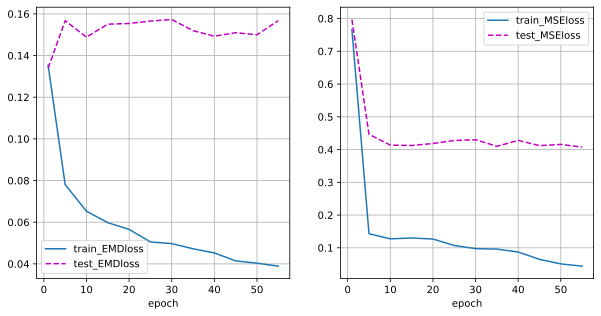

In [ ]:
finetune= net
train(train_iter,test_iter,finetune,1e-5,0, 100, save_name="resnet152_bin100_EMD_softmax")

In [119]:
bins=[]
finetune.load_state_dict(torch.load('weight/test3_bin100_best.pt'))
for i in range(50):
    bins.append(-3 + i* 6.5/50)
mean_bins=[-3]
for i in range(49):
    mean=(bins[i]+bins[i+1])/2
    mean_bins.append(mean)
device=try_gpu()
mse=[]
for x,y in test_iter:
    x = x.to(device)
    y = y.to(device)
    y_hat=finetune(x)
    # print(y_hat,y)
    sum_hat=[]
    sum_label=[]
    y.to("cpu")
    y_hat.to("cpu")
    y=y.squeeze()
    for j in range (y.shape[0]):
        hat=0
        label=0
        for i in range(50):
            hat+= (mean_bins[i]* y_hat[j][i]).item()
            label+= (mean_bins[i]* y[j][i]).item()    
        sum_hat.append(hat)
        sum_label.append(label)
    mse.append(np.square((np.array(sum_hat)-np.array(sum_label))).mean())
print("MSE Loss: ", np.array(mse).mean())

MSE Loss:  2.188336001159296


In [97]:
for a,b in zip(sum_hat, sum_label):
    print(a, b)
    print("MSE_Loss: ", (a-b)**2)
# print(y.shape)

1.0872085022274405 0.3448999874526635
MSE_Loss:  0.5510219311071353
0.678780574729899 0.0
MSE_Loss:  0.46074306863065195
1.0551163987256587 0.6545000057667494
MSE_Loss:  0.16049349430740723
0.5622096484294161 1.0511000752449036
MSE_Loss:  0.2390138494318295
0.5772434531245381 0.0
MSE_Loss:  0.3332100041751408
0.4233381040976383 0.0
MSE_Loss:  0.17921515038098282
0.5627916423691204 2.4158000499010086
MSE_Loss:  3.4336401583838643
0.9259936277667293 0.0
MSE_Loss:  0.8574641986645881
0.8906066975614522 0.0
MSE_Loss:  0.7931802897413159
1.055257539555896 0.0
MSE_Loss:  1.1135684747895636
0.43403135472908616 0.0
MSE_Loss:  0.18838321688796583
1.0889007369987667 2.4834000673145056
MSE_Loss:  1.9446283822510444
0.48708587709552376 0.0
MSE_Loss:  0.23725265166591566


Average Loss:  0.4789889780506834


0

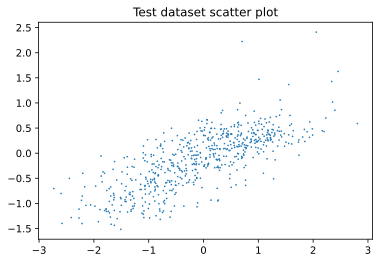

In [83]:
bins=[]
for i in range(100):
    bins.append(-3.5 + i* 7/100)
mean_bins=[-3.5]
for i in range(99):
    mean=(bins[i]+bins[i+1])/2
    mean_bins.append(mean)

evaluate_accuracy_with_plot(finetune, test_iter,device=try_gpu(),title = "Test dataset scatter plot",mean_bins=mean_bins,show_scatter=True)

Average Loss:  0.09592912959532451


0

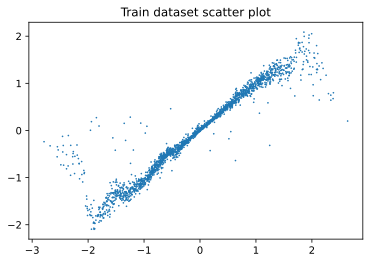

In [84]:
evaluate_accuracy_with_plot(finetune, train_iter,device=try_gpu(),title = "Train dataset scatter plot" ,mean_bins=mean_bins, show_scatter=True)

In [29]:
finetune.load_state_dict(torch.load('weight/test_best.pt'))

<All keys matched successfully>

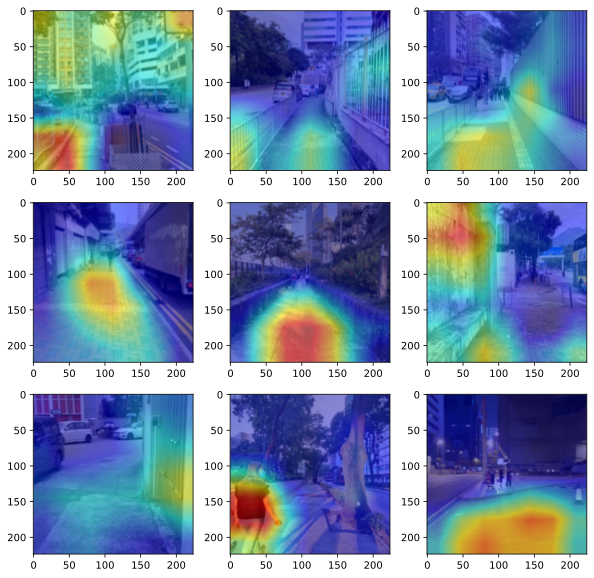

In [91]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.transforms.functional as F
# finetune.load_state_dict(torch.load('weight/test_best.pt'))

net=finetune
net.eval()
f=[file for file in os.listdir("data/train") if os.path.isfile(os.path.join("data/train",file))]
fig,axe=plt.subplots(3 , 3 ,figsize=(10,10))
def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result
for x,y in test_iter:
    x=x[:9]
    y=y[:9]
    for i in range(9):
        image = x[i].detach()
        image = F.to_pil_image(image)
        # idx=random.randint(0,len(f)-1)
        # filename=os.path.join("data/train", f[idx])
        # image=Image.open(filename)
        # image=x[i]
        # image=image.resize((224,224))
        image_float_np = np.float32(image) / 255
        transform = torchvision.transforms.Compose([
    #         torchvision.transforms.Resize((224,224)),
            torchvision.transforms.ToTensor()
        ])
        input_tensor =  transform(image)
        # image=image.reshape(224,224,3)
        input_tensor = input_tensor.unsqueeze(0)
        # resnet
        target_layer=net.layer4[-1]
        # # target_layer=net[0][7][-1]
#         target_layer=net.net.resnet.layer4[-1]
        cam = GradCAM(model=net, target_layers=[target_layer], use_cuda=True)
        grayscale_cam = cam(input_tensor=input_tensor, aug_smooth=True)
            # In this example grayscale_cam has only one image in the batch:
        grayscale_cam = grayscale_cam[0, :]
        # grayscale_cam = grayscale_cam[0, :]
        # print(image_float_np.shape, grayscale_cam.shape)
        visualization = show_cam_on_image(image_float_np,grayscale_cam, use_rgb=True)
        # print(visualization.shape)
#         result=net(input_tensor.to(try_gpu()))
    #     regression
        # # print(result)
        # # Image.fromarray(visualization)
        # axe[i//3 , i%3].imshow(visualization)
        # axe[i//3 , i%3].set_xlabel(result.item())
    #     classification
        # axe[i//3 , i%3].imshow(visualization)
        # result= f"P:{str(result.item())[:5]} GT:{str(y[i].item())[:5]}"
        # result=result.argmax(dim = 1)
        # axe[i//3 , i%3].set_xlabel(result)
        # swin
        # target_layers = [net[0].layers[-1].blocks[-1].norm1]
#         target_layers = [finetune.net.swin.layers[-1].blocks[-1].norm1]
        
#         cam=GradCAM(model=net, target_layers=target_layers, reshape_transform=reshape_transform)
#         grayscale_cam = cam(input_tensor=input_tensor.to(try_gpu()), aug_smooth=True)
#             # In this example grayscale_cam has only one image in the batch:
#         grayscale_cam = grayscale_cam[0, :]
#         visualization = show_cam_on_image(image_float_np,grayscale_cam, use_rgb=True)
#         # print(visualization.shape)
#         # input_tensor2 =  reshape_transform(input_tensor)
#         result=net(input_tensor.to(try_gpu()))
    #     regression
        # print(result)
        # Image.fromarray(visualization)
        axe[i//3 , i%3].imshow(visualization)
#         axe[i//3 , i%3].set_xlabel(result.item())
    #     classification
#         axe[i//3 , i%3].imshow(visualization)
        # result=result.argmax(dim = 1)
#         result= f"P:{str(result.item())[:5]} GT:{str(y[i].item())[:5]}"
    
#         axe[i//3 , i%3].set_xlabel(result)
    break